In [1]:
%matplotlib inline
from pyvista import set_plot_theme

set_plot_theme("document")

# 3.1: Simple example of kriging in gempy GemPy 中的简单克里金插值示例


In this notebook it will be shown how to create a kriged or simulated
field in a simple geological model in gempy. We start by creating a
simple model with three horizontally layered units, as shown in the
gempy examples.

在本笔记本中，将展示如何在 GemPy 的简单地质模型中创建克里金插值场或模拟场。我们首先创建一个具有三个水平分层单元的简单模型，如 GemPy 示例所示。


Importing GemPy

导入 GemPy


In [2]:
import os

import gempy_viewer as gpv
import matplotlib.pyplot as plt

# Importing auxiliary libraries
import numpy as np

# new for this
from gempy_plugins.kriging import kriging

import gempy as gp

np.random.seed(5555)

Setting Backend To: AvailableBackends.numpy


In [3]:
# 修复 OMP: Error #15 冲突
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

Creating the model by importing the input data and displaying it:

通过导入输入数据并显示它来创建模型：


In [4]:
data_path = os.path.abspath("../")

geo_data: gp.data.GeoModel = gp.create_geomodel(
    project_name="kriging",
    extent=[0, 1000, 0, 50, 0, 1000],
    resolution=[50, 10, 50],
    refinement=1,
    importer_helper=gp.data.ImporterHelper(
        path_to_orientations=data_path + "/data/model1_orientations.csv",
        path_to_surface_points=data_path + "/data/model1_surface_points.csv",
    ),
)

Setting and ordering the units and series:

设置和排序单元及系列：


In [5]:
gp.map_stack_to_surfaces(
    gempy_model=geo_data,
    mapping_object={"Strat_Series": ("rock2", "rock1"), "Basement_Series": ("basement")},  # type: ignore
)

Could not find element 'basement' in any group.


StructuralFrame(
	structural_groups=[
StructuralGroup(
	name=Strat_Series,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=rock2,
	color=#9f0052,
	is_active=True
),
Element(
	name=rock1,
	color=#015482,
	is_active=True
)
]
)
],
	fault_relations=
[[False]],

Calculating the model:

计算模型：


no mesh computed as basically 2D model

由于基本上是 2D 模型，因此不计算网格


In [6]:
sol = gp.compute_model(geo_data)

Setting Backend To: AvailableBackends.numpy


c:\Users\WangQinZhuo\miniconda3\envs\transform2021_devito\lib\site-packages\gempy_engine\modules\activator\_soft_segment.py:95: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + bt.t.exp(x))


Using sequential processing for 2 surfaces


So here is the very simple, basically 2D model that we created:

这就是我们创建的非常简单的、基本上是 2D 的模型：


c:\Users\WangQinZhuo\miniconda3\envs\transform2021_devito\lib\site-packages\gempy_viewer\API\_plot_2d_API.py:176: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


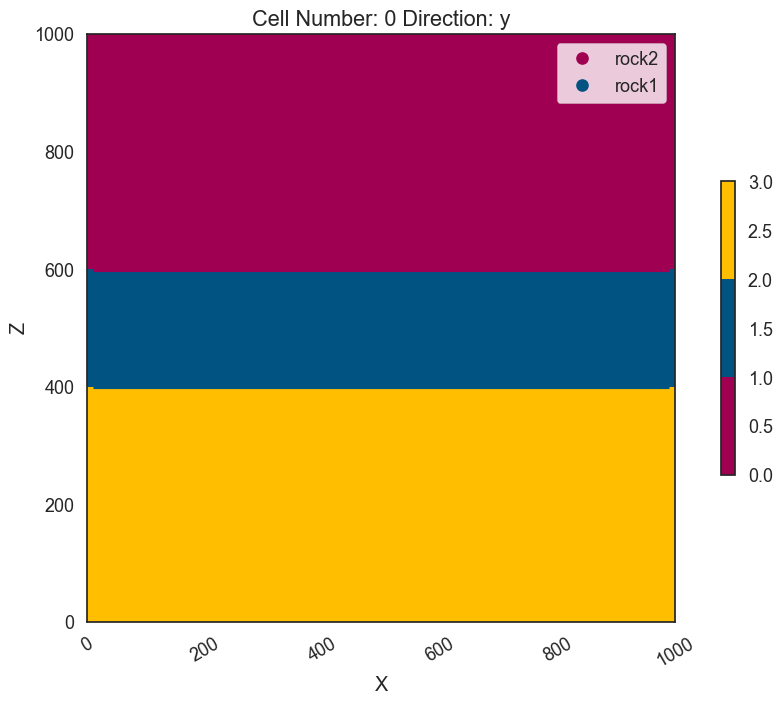

In [7]:
gpv.plot_2d(geo_data, cell_number=0, show_data=False)

## 1) Creating domain 1) 创建域

Let us assume we have a couple of measurements in a domain of interest
within our model. In our case the unit of interest is the central rock
layer (rock1). In the kriging module we can define the domain by
handing over a number of surfaces by id - in this case the id of rock1
is 2. In addition we define four input data points in cond_data, each
defined by x,y,z coordinate and a measurement value.

假设我们在模型中的感兴趣域内有一些测量值。在我们的例子中，感兴趣的单元是中间的岩层 (rock1)。在克里金模块中，我们可以通过传递 ID 来定义由多个表面组成的域 - 在本例中，rock1 的 ID 为 2。此外，我们在 `cond_data` 中定义了四个输入数据点，每个点由 x, y, z 坐标和一个测量值定义。


conditioning data (data measured at locations)

条件数据（在特定位置测量的数据）


In [8]:
cond_data = np.array([[100, 0.5, 500, 2], [900, 0.5, 500, 1], [500, 0.5, 550, 1], [300, 0.5, 400, 5]])

creating a domain object from the gempy solution, a defined domain conditioning data

从 GemPy 解、定义的域和条件数据创建一个域对象


In [9]:
domain = kriging.Domain(model_solutions=sol, transform=geo_data.input_transform, domain=[2], data=cond_data)

## 2) Creating a variogram model 2) 创建变差函数模型


In [10]:
variogram_model = kriging.VariogramModel(theoretical_model="exponential", range_=200, sill=np.var(cond_data[:, 3]))  # type: ignore

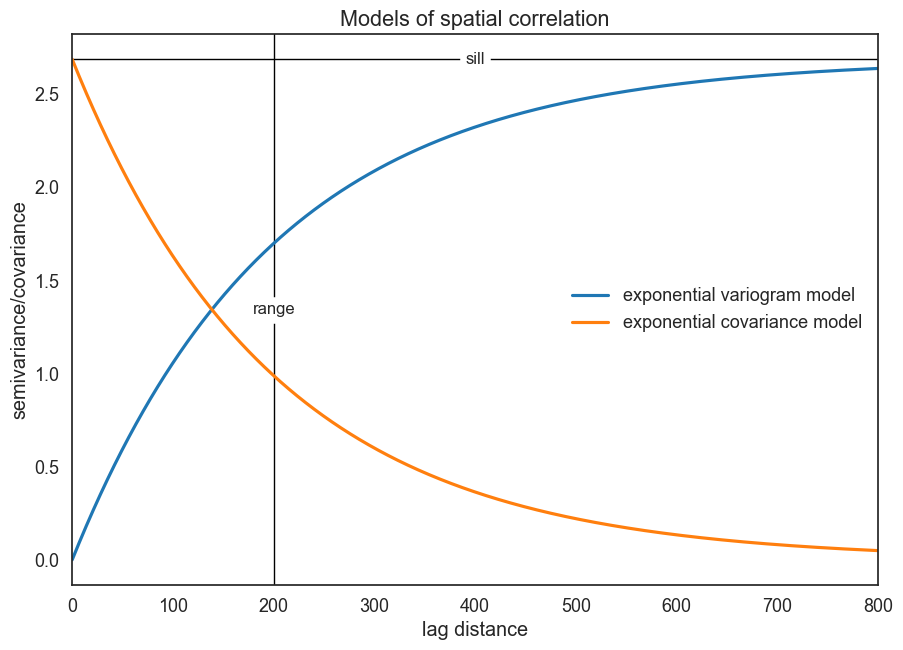

In [11]:
variogram_model.plot(type_="both", show_parameters=True)
plt.show()

## 3) Kriging interpolation 克里金插值


In the following we define an object called kriging_model and set all
input parameters. Finally we generate the kriged field.

在下文中，我们定义一个名为 `kriging_model` 的对象并设置所有输入参数。最后，我们生成克里金插值场。


In [12]:
kriging_solution = kriging.create_kriged_field(domain, variogram_model)

The result of our calculation is saved in the following dataframe,
containing an estimated value and the kriging variance for each point in
the grid:

我们的计算结果保存在以下数据框中，包含网格中每个点的估计值和克里金方差：


In [13]:
kriging_solution.results_df.head()

,X,Y,Z,estimated value,estimation variance
0,10.0016,2.5016,410.0016,2.241542,2.103698
1,10.0016,2.5016,430.0016,2.193555,1.979810
2,10.0016,2.5016,450.0016,2.144345,1.865440
3,10.0016,2.5016,470.0016,2.097883,1.774970
4,10.0016,2.5016,490.0016,2.058535,1.724997


It is also possible to plot the results in cross section similar to the
way gempy models are plotted.

也可以像绘制 GemPy 模型一样，以剖面形式绘制结果。


c:\Users\WangQinZhuo\miniconda3\envs\transform2021_devito\lib\site-packages\gempy_plugins\kriging\kriging.py:335: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_2d.fig.show()


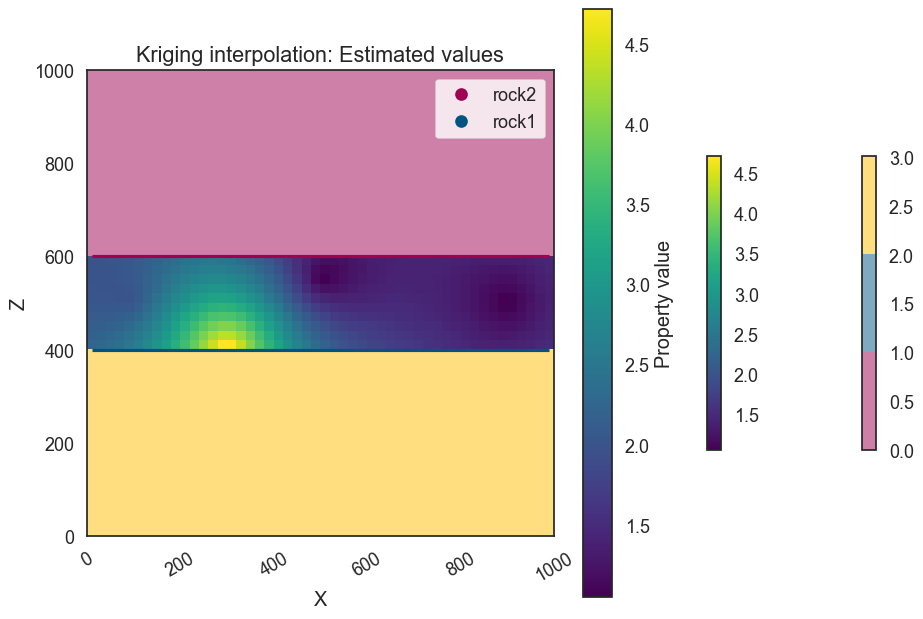

In [14]:
from gempy_viewer.modules.plot_2d.visualization_2d import Plot2D

plot_2d: Plot2D = gpv.plot_2d(
    model=geo_data, cell_number=0, show_data=False, show=False, kwargs_lithology={"alpha": 0.5}
)
kriging.plot_kriging_results(
    geo_data=geo_data,
    kriging_solution=kriging_solution,
    plot_2d=plot_2d,
    title="Kriging interpolation: Estimated values",
    result_column=["estimated value"],
)

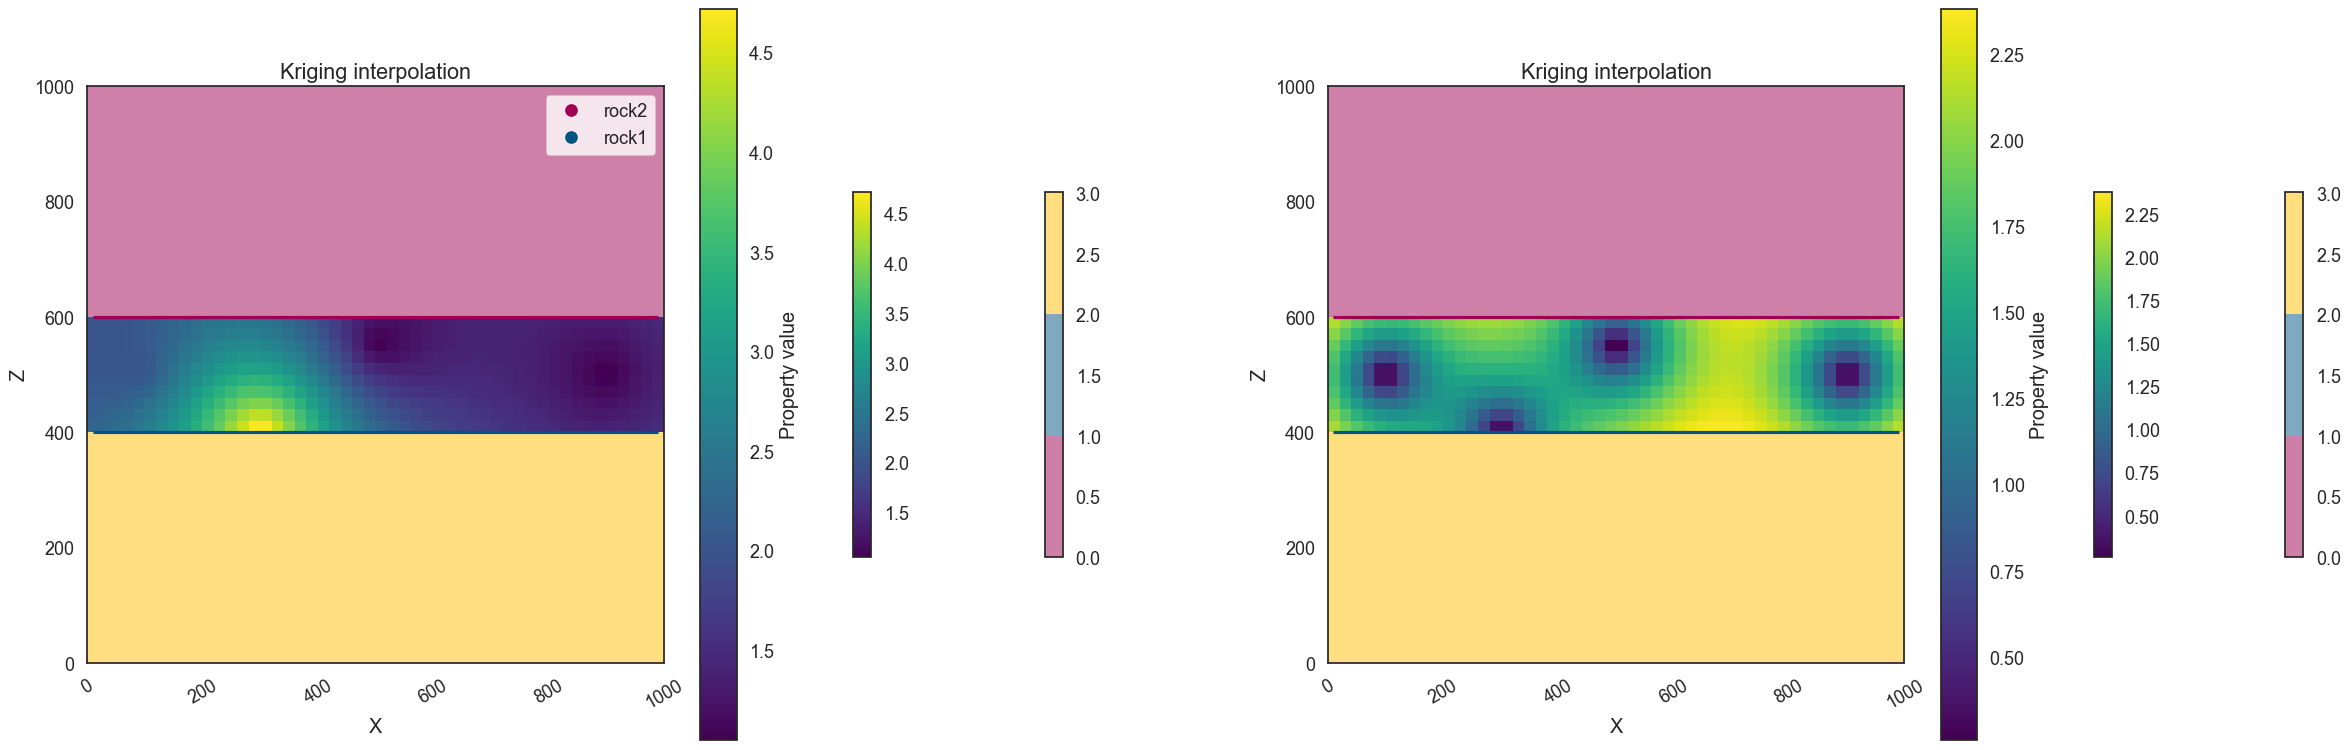

In [15]:
plot_2d_both = gpv.plot_2d(
    model=geo_data, cell_number=[0, 0], show_data=False, show=False, kwargs_lithology={"alpha": 0.5}
)

kriging.plot_kriging_results(
    geo_data=geo_data,
    kriging_solution=kriging_solution,
    plot_2d=plot_2d_both,
    title="Kriging interpolation",
    result_column=["estimated value", "estimation variance"],
)

## 4) Simulated field (未读)

Based on the same objects (domain and varigoram model) also a simulated
field (stationary Gaussian Field) can be generated. A Sequential
Gaussian Simulation approach is applied in this module:


In [ ]:
solution_sim = kriging.create_gaussian_field(domain, variogram_model)

In [ ]:
solution_sim.results_df.head()

In [ ]:
solution_sim.results_df["estimated value"]

In [ ]:
plot_2d: Plot2D = gpv.plot_2d(
    model=geo_data, cell_number=0, show_data=False, show=False, kwargs_lithology={"alpha": 0.5}
)
kriging.plot_kriging_results(
    geo_data=geo_data,
    kriging_solution=solution_sim,
    plot_2d=plot_2d,
    title="Kriging interpolation: Estimated values",
    result_column=["estimated value"],
)

In [ ]:
plot_2d_both = gpv.plot_2d(
    model=geo_data, cell_number=[0, 0], show_data=False, show=False, kwargs_lithology={"alpha": 0.5}
)

kriging.plot_kriging_results(
    geo_data=geo_data,
    kriging_solution=solution_sim,
    plot_2d=plot_2d_both,
    title="Kriging interpolation: Estimated values",
    result_column=["estimated value", "estimation variance"],
)
# sphinx_gallery_thumbnail_number = 3